# Basic water mass analysis example notebook for MPAS-Ocean

Uses `watermasstools.py` in the `modules` directory.

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import yaml
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools
import watermasstools as wmttools

# Set plot font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

In [50]:
# Regions
regions = ['Greenland Sea', 'Iceland Basin', 'Irminger Sea', 'Labrador Sea', 'Norwegian Sea', 'North Atlantic Ocean']

# Initialize storage dict
meshes = ['LRv2', 'LRv2_1']
wmt = {mesh: {'1D': [], '2D': []} for mesh in meshes}

# Months to process
months = np.arange(1, 13, dtype=int)
years = np.arange(524, 534)
# Loop though meshes
for mesh in meshes:

    # Load paths
    with open(f'../yaml/paths_{mesh}.yaml') as f:
        paths = yaml.safe_load(f)
    resultspath = paths['results']['0501-0502'] + '/' + paths['prefix']

    # Load mask variables
    with xr.open_dataset(paths['maskfile']) as ds:
        regionNames = ds.regionNames.values.astype(str)
        regionMasks = ds.regionCellMasks.values

    # Build subdomain to include only points in region list
    index = np.isin(regionNames, regions)
    subdomain, = np.where(regionMasks[:, index].sum(axis=1).astype(bool))

    # Load mesh variables and build coords dict
    with xr.open_dataset(paths['meshfile']) as ds:
        coords = {
            'area': ds.areaCell.values[subdomain],
            'nCells': ds.nCells.values[subdomain],
            'regionNames': regionNames,
            'regionMasks': regionMasks[subdomain, :].astype(bool),
        }

    # Initialize remapping variables (define bbox here if you don't want the whole globe)
    remapvars = pptools.build_remapper(paths['meshfile'], bbox=[-100, 20, 0, 80])
    
    for yy in np.arange(len(years)):
        # Loop through months
        year = years[yy]
        for month in tqdm(months, desc=f'Loading {mesh} results'):
            #ii = yy*12 + month 
            # Load results
            with xr.open_dataset(resultspath + f'.{year:04d}-{month:02d}-01.nc') as ds:

                # Get S, T and statevars
                names, prefix = ['salinity', 'temperature'], 'timeMonthly_avg_activeTracers_'
                S, T = [ds[prefix + name][0, :, 0].values[subdomain] for name in names]
                sigmaTheta, heatFactor, saltFactor = wmttools.calc_state_variables(S, T)

                # Get buoyancy fluxes
                fluxes = wmttools.build_combined_fluxes(ds, heatFactor, saltFactor, subdomain=subdomain)

            # Calculate 1D water mass transformation over regions
            wmt[mesh]['1D'].append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, regions=regions))

            # Calculate 2D water mass transformation
            wmt[mesh]['2D'].append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, remapvars=remapvars))

    # Concatenate months
    for ctgy in wmt[mesh]:
        wmt[mesh][ctgy] = xr.concat(wmt[mesh][ctgy], pd.Index(np.arange(1, len(years)*12+1), name='months'))

Loading LRv2 results: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.64s/it]
/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.1_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
Loading LRv2_1 results: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.36s/it]
/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.1_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d f

In [18]:
years = np.arange(501, 503)

In [20]:
np.arange(1, len(years)*12+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [26]:
# xr.Dataset structure for the 1D results
wmt['LRv2']['1D']


<xarray.Dataset>
Dimensions:              (months: 120, sigmaBins: 81, regionNames: 6)
Coordinates:
  * sigmaBins            (sigmaBins) float64 21.0 21.1 21.2 ... 28.8 28.9 29.0
  * regionNames          (regionNames) <U20 'Greenland Sea' ... 'North Atlant...
  * months               (months) int64 1 2 3 4 5 6 ... 115 116 117 118 119 120
Data variables:
    heatTransformation   (months, sigmaBins, regionNames) float64 0.0 ... 0.0
    saltTransformation   (months, sigmaBins, regionNames) float64 0.0 ... 0.0
    totalTransformation  (months, sigmaBins, regionNames) float64 0.0 ... 0.0

In [7]:
# xr.Dataset structure for the 2D results
wmt['LRv2']['2D']

<xarray.Dataset>
Dimensions:              (months: 12, sigmaBins: 81, lat: 160, lon: 240)
Coordinates:
  * sigmaBins            (sigmaBins) float64 21.0 21.1 21.2 ... 28.8 28.9 29.0
  * lat                  (lat) float64 0.25 0.75 1.25 1.75 ... 78.75 79.25 79.75
  * lon                  (lon) float64 -99.75 -99.25 -98.75 ... 19.25 19.75
  * months               (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    heatTransformation   (months, sigmaBins, lat, lon) float64 0.0 0.0 ... nan
    saltTransformation   (months, sigmaBins, lat, lon) float64 0.0 0.0 ... nan
    totalTransformation  (months, sigmaBins, lat, lon) float64 0.0 0.0 ... nan

In [33]:
wmt.coordinates['sigmaBins']

AttributeError: 'dict' object has no attribute 'coordinates'

In [51]:
wmt_524to534=wmt

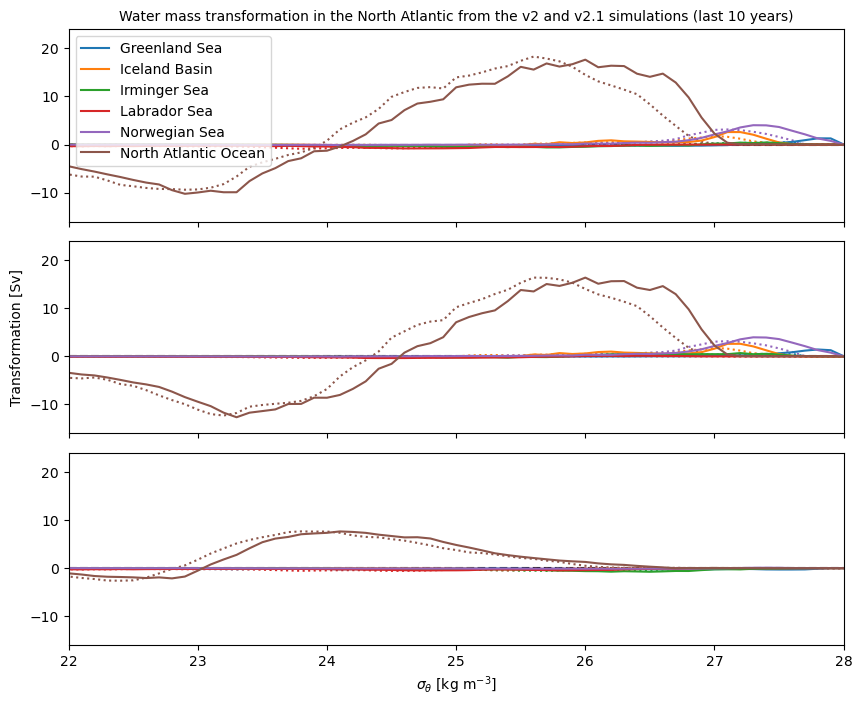

<Figure size 640x480 with 0 Axes>

In [52]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.1})
palette = plt.get_cmap('tab10').colors
xlim, ylim = [22, 28], [-16, 24]

# Loop through panels and transformation categories
for ax, ctgy in zip(axs, ['total', 'heat', 'salt']):
    
    # Loop through meshes and regions
    for mesh, ls in zip(['LRv2', 'LRv2_1'], [':', '-']):
        for region, color in zip(regions, palette):
            
            # Plot transformation averaged over first 12 months of simulation
            label = region if ls == '-' else None
            y = wmt[mesh]['1D'][ctgy + 'Transformation'].sel(regionNames=region).mean(dim='months')
            x = y.sigmaBins
            ax.plot(x, y, ls, color=color, label=label)
    
    # Formatting
    ax.plot(xlim, [0, 0], 'k--', zorder=-10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if ctgy != 'salt':
        ax.xaxis.set_ticklabels('')

# Final formatting
axs[2].set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
axs[1].set_ylabel('Transformation [Sv]')
axs[0].set_title('Water mass transformation in the North Atlantic from the v2 and v2.1 simulations (last 10 years)')
axs[0].legend()
plt.show()
plt.savefig('wmt1D_524-533.png')

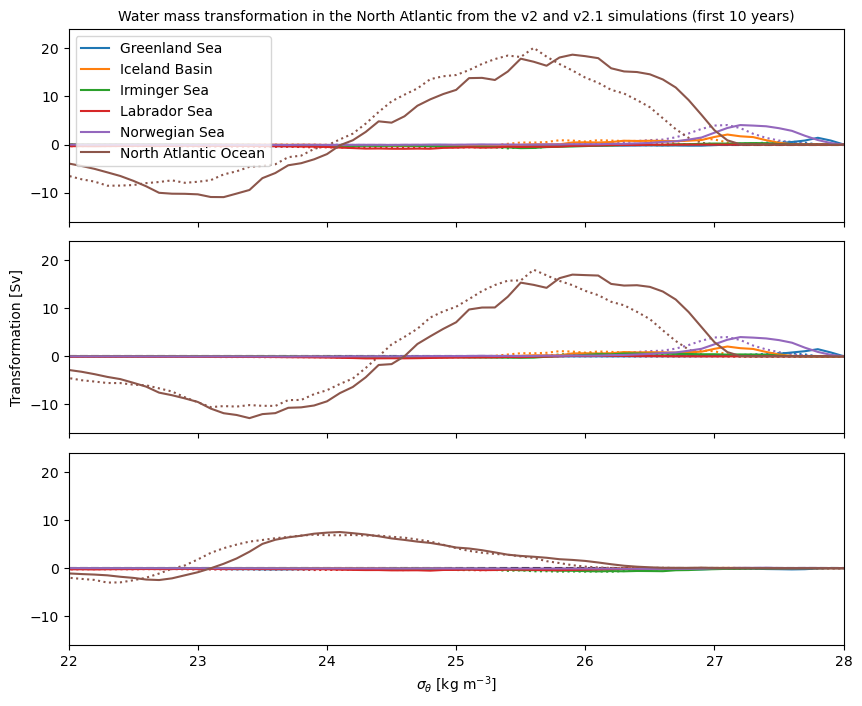

<Figure size 640x480 with 0 Axes>

In [27]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.1})
palette = plt.get_cmap('tab10').colors
xlim, ylim = [22, 28], [-16, 24]

# Loop through panels and transformation categories
for ax, ctgy in zip(axs, ['total', 'heat', 'salt']):
    
    # Loop through meshes and regions
    for mesh, ls in zip(['LRv2', 'LRv2_1'], [':', '-']):
        for region, color in zip(regions, palette):
            
            # Plot transformation averaged over first 12 months of simulation
            label = region if ls == '-' else None
            y = wmt[mesh]['1D'][ctgy + 'Transformation'].sel(regionNames=region).mean(dim='months')
            x = y.sigmaBins
            ax.plot(x, y, ls, color=color, label=label)
    
    # Formatting
    ax.plot(xlim, [0, 0], 'k--', zorder=-10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if ctgy != 'salt':
        ax.xaxis.set_ticklabels('')

# Final formatting
axs[2].set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
axs[1].set_ylabel('Transformation [Sv]')
axs[0].set_title('Water mass transformation in the North Atlantic from the v2 and v2.1 simulations (first 10 years)')
axs[0].legend()
plt.show()
#plt.savefig('wmt1D_501-510.png')

(160, 240)
(160, 240)
(160, 240)


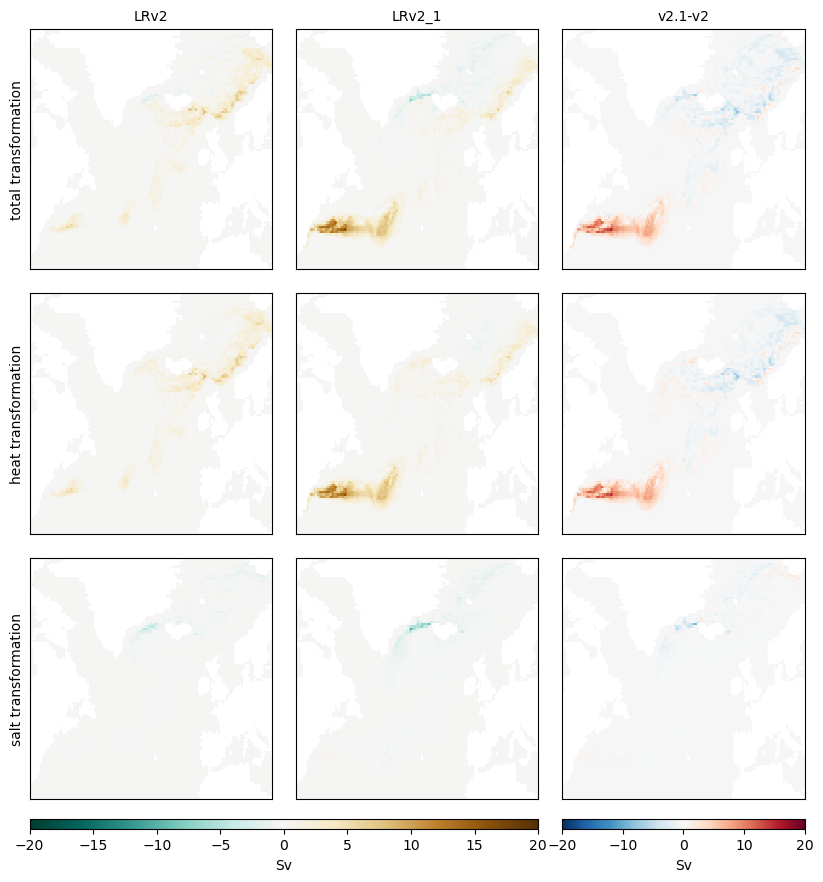

In [62]:


# Make figure
fig, axs = plt.subplots(3, 3, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
xlim, ylim = [-80, 20], [30, 80]

# Loop through rows and transformation categories
for row, ctgy in zip(axs, ['total', 'heat', 'salt']):
    row[0].set_ylabel(ctgy + ' transformation')
    
    # Loop through panels and meshes
    residual = []
    for ax, mesh in zip(row, meshes):
            
        # Plot transformation averaged over first 12 months of simulation at sigma=27.3
        z = wmt[mesh]['2D'][ctgy + 'Transformation'].sel(sigmaBins=26.8).mean(dim='months')#-wmt[mesh]['2D'][ctgy + 'Transformation'].sel(sigmaBins=27.).mean(dim='months')
        x, y = z.lon, z.lat
        c1 = ax.pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='BrBG_r')
        residual.append(z)
    
    # Plot residual
    print(np.shape(residual[0]))
    #z = np.subtract(*residual)
    z = residual[1]-residual[0]
    c2 = row[2].pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='RdBu_r')
    
# Formatting
pos = []
for col, title in zip(axs.T, meshes + ['v2.1-v2']):
    col[0].set_title(title)
    pos.append(col[2].get_position())
    for ax in col:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

# Add colorbars
cax1 = fig.add_axes([pos[0].x0, 0.08, pos[1].x1 - pos[0].x0, 0.01])
cax2 = fig.add_axes([pos[2].x0, 0.08, pos[2].width, 0.01])
fig.colorbar(c1, cax1, orientation='horizontal', label='Sv')
fig.colorbar(c2, cax2, orientation='horizontal', label='Sv')
plt.show()

#plt.savefig('wmt2D_524-533_sig273.png')

(160, 240)
(160, 240)
(160, 240)


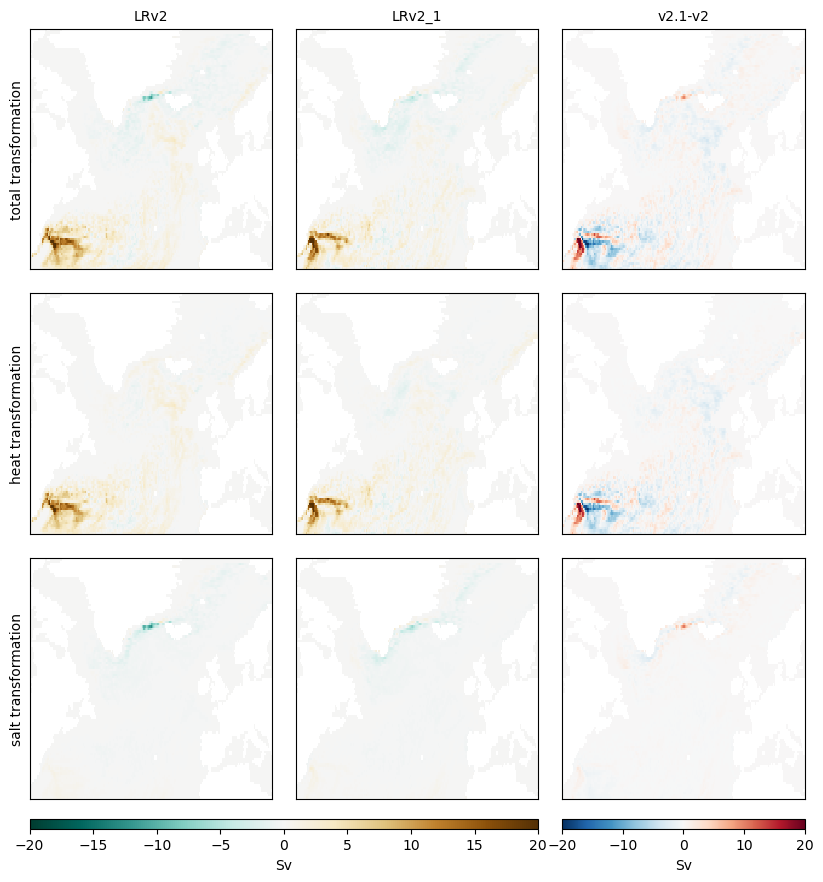

<Figure size 640x480 with 0 Axes>

In [49]:


# Make figure
fig, axs = plt.subplots(3, 3, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
xlim, ylim = [-80, 20], [30, 80]

# Loop through rows and transformation categories
for row, ctgy in zip(axs, ['total', 'heat', 'salt']):
    row[0].set_ylabel(ctgy + ' transformation')
    
    # Loop through panels and meshes
    residual = []
    for ax, mesh in zip(row, meshes):
            
        # Plot transformation averaged over first 12 months of simulation at sigma=27.3
        z = wmt[mesh]['2D'][ctgy + 'Transformation'].sel(sigmaBins=25.7).mean(dim='months')
        x, y = z.lon, z.lat
        c1 = ax.pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='BrBG_r')
        residual.append(z)
    
    # Plot residual
    print(np.shape(residual[0]))
    #z = np.subtract(*residual)
    z = residual[1]-residual[0]
    c2 = row[2].pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='RdBu_r')
    
# Formatting
pos = []
for col, title in zip(axs.T, meshes + ['v2.1-v2']):
    col[0].set_title(title)
    pos.append(col[2].get_position())
    for ax in col:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

# Add colorbars
cax1 = fig.add_axes([pos[0].x0, 0.08, pos[1].x1 - pos[0].x0, 0.01])
cax2 = fig.add_axes([pos[2].x0, 0.08, pos[2].width, 0.01])
fig.colorbar(c1, cax1, orientation='horizontal', label='Sv')
fig.colorbar(c2, cax2, orientation='horizontal', label='Sv')
plt.show()

plt.savefig('wmt2D_524-533_sig257.png')

In [ ]:


# Plotting info
varnames = ['temperature', 'salinity', 'dThreshMLD']
cmaps = ['inferno', 'viridis', 'Blues']
clims = [[-5, 30, 8], [29, 37.5, 4], [0, 500, 500]]
titles = ['Surface temperature', 'Surface salinity', 'Mixed layer depth']
units = ['[$^{\circ}$C]', '[PSU]', '[m]']
props = {'fc': 'w', 'boxstyle': 'round', 'alpha': 0.9}

# Make figure
fig, axs = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.05})

# Loop through time ranges
for col, varname, cmap, clim, title, unit in zip(axs.T, varnames, cmaps, clims, titles, units):

    # --- Plot meshes ---------
    res = []
    for ax, mesh in zip(col, ds):

        # Slice dataset
        ds_slc = ds[mesh]['1997-2006'].sel(depths=0, months=[12, 1, 2]).mean(dim='months')

        # Plot sliced dataset
        c1, variable = viz.plot_2Dpanel(
            ax, ds_slc, varname, clim=clim[:2], cmap=cmap, plot_sigma=True,
        )
        res.append(variable)

    # --- Plot residual -------
    res = np.subtract(*res)
    pos = col[2].get_position()
    col[2].set_position([pos.x0, pos.y0-0.05, pos.width, pos.height])
    c2, _ = viz.plot_2Dpanel(col[2], res, clim=[-clim[2], clim[2]], cmap='RdBu_r')

    # Add colorbars
    cax1 = fig.add_axes([pos.x0, pos.y0+0.24, pos.width, 0.01])
    cax2 = fig.add_axes([pos.x0, pos.y0-0.07, pos.width, 0.01])
    fig.colorbar(c1, cax=cax1, label=unit, orientation='horizontal')
    fig.colorbar(c2, cax=cax2, label=unit, orientation='horizontal')
    col[0].set_title(title)
    if varname == varnames[0]:
        for ax, label in zip(col, ['LR', 'HR', 'LR-HR']):
            ax.text(0.03, 0.03, label, transform=ax.transAxes, bbox=props)

fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/biases.pdf', bbox_inches='tight')



In [ ]:
# Mask stuff

#regionList = ['Greenland Sea', 'Iceland Basin', 'Irminger Sea', 'Labrador Sea', 'Norwegian Sea']

# Load mask variables
#with xr.open_dataset(maskfile) as ds:
#    regionNames = ds.regionNames.values.astype(str)
#    regionMasks = ds.regionCellMasks

# Subdomain
#index = np.isin(regionNames, regionList)
#subdomain = regionMasks[:, index].sum(dim='nRegions').astype(bool)

In [2]:
# Paths
meshfile = '/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
maskfile = '/pscratch/sd/b/bmoorema/maskfiles/EC30to60E2r2_NAmodewatermasks20230915.nc'
#resultspath = '/pscratch/sd/k/katsmith/v2.1Paper/v2Extension/'
#filename = 'v2.LR.piControl.mpaso.hist.am.timeSeriesStatsMonthly.0501-01-01.nc'
resultspath = '/pscratch/sd/a/abarthel/'
filename = 'v2.LR.piControl.mpaso.hist.am.timeSeriesStatsMonthly.annual.0531-0533.nc'

In [56]:
# Load mesh variables
with xr.open_dataset(meshfile) as ds:
    areaCell = ds.areaCell
    #lonCell = np.rad2deg(ds.lonCell)
    #latCell = np.rad2deg(ds.latCell)
    #lonCell[lonCell > 180] = lonCell[lonCell > 180] - 360

# Load results
with xr.open_dataset(resultspath + filename) as ds:
    
    # Get S, T and statevars
    names, prefix = ['salinity', 'temperature'], 'timeMonthly_avg_activeTracers_'
    S, T = [ds[prefix + name][0, :, 0] for name in names]
    statevars = wmttools.calc_state_variables(S, T)
    
    # Get buoyancy fluxes
    fluxes = wmttools.build_combined_fluxes(ds, statevars)
    
    # Calculate water mass transformation
    wmt = wmttools.calc_wmt(fluxes, statevars['sigmaTheta'], areaCell)

/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.1_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [57]:
wmt_annual531to3= wmt

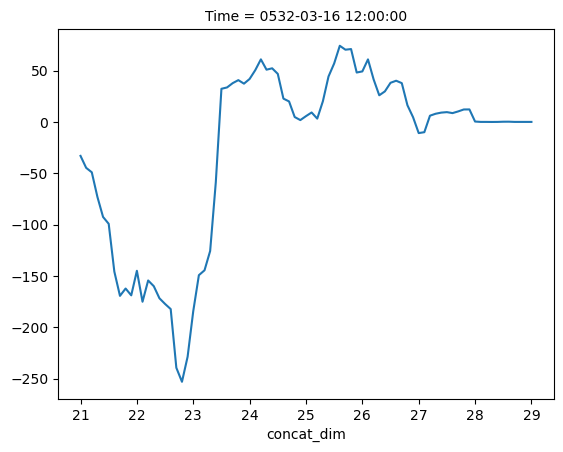

In [23]:
# Plot water mass transformation # March of year 531-533 v2.1
wmt['totalTrans'].plot()

In [ ]:
# Don't run below!

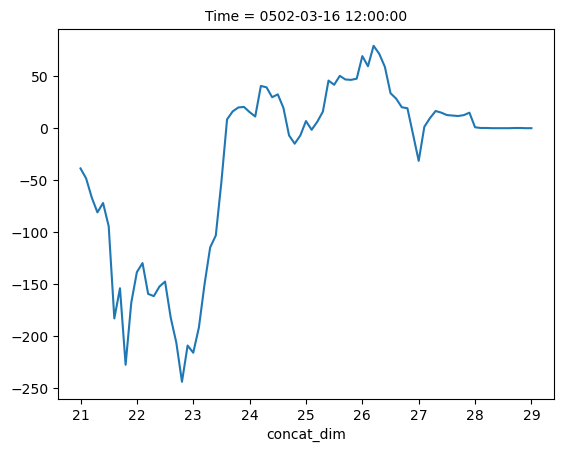

In [19]:
# Plot water mass transformation # March of year 501-503 v2.1
wmt['totalTrans'].plot()

In [20]:
wmt_march501to3_v2_1 = wmt

In [15]:
wmt_march531to3 = wmt

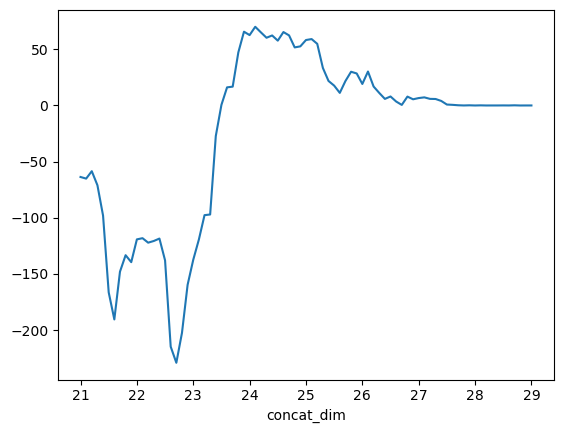

In [14]:
# Plot water mass transformation # March of year 531-533
wmt['totalTrans'].plot()

In [11]:
wmt_march501to3 = wmt

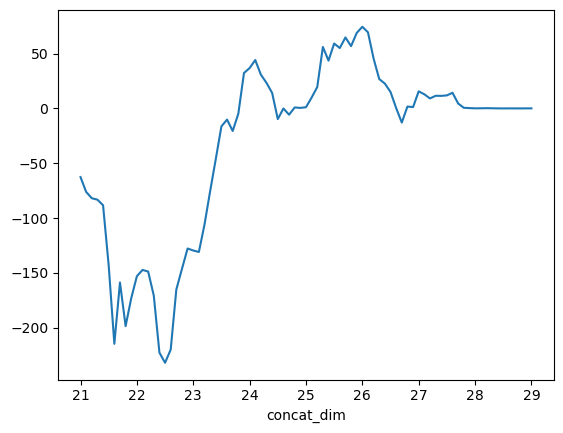

In [10]:
# Plot water mass transformation # March of year 501-503
wmt['totalTrans'].plot()

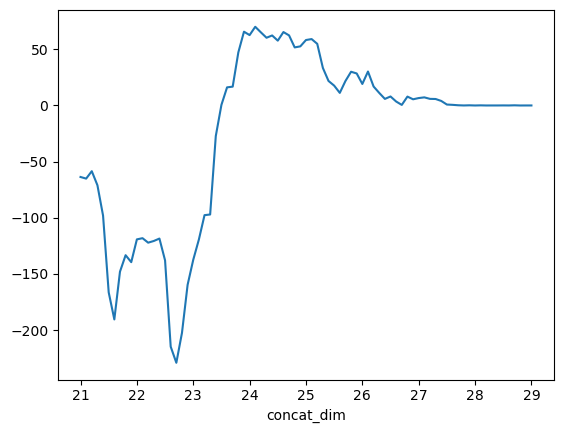

In [14]:
# Plot water mass transformation # March of year 531-533
wmt['totalTrans'].plot()

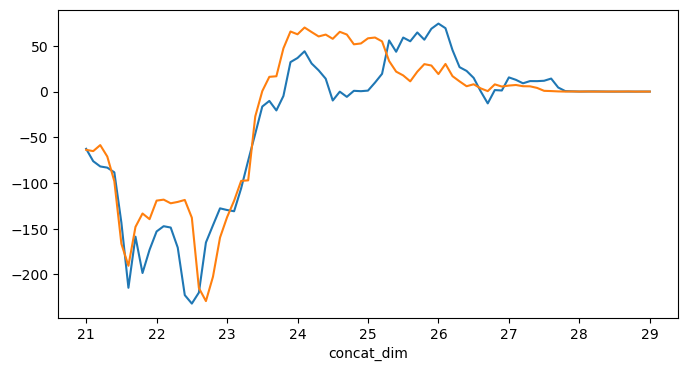

In [40]:
# Plot water mass transformation # March of year 531-533
fig = plt.figure (figsize= [8,4])
wmt_march501to3['totalTrans'].plot()
wmt_march531to3['totalTrans'].plot()

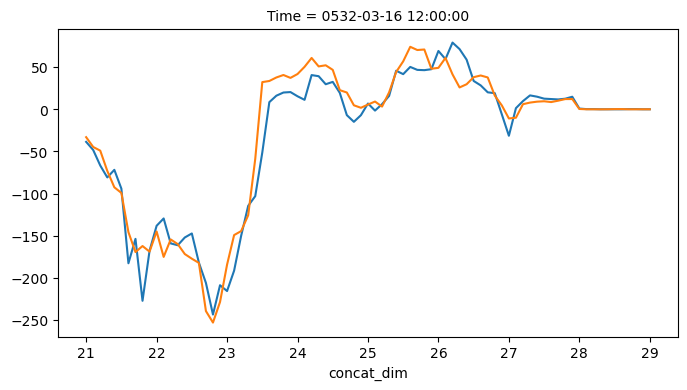

In [41]:
# Plot water mass transformation # March of year 531-533
fig = plt.figure (figsize= [8,4])
wmt_march501to3_v2_1['totalTrans'].plot()
wmt_march531to3_v2_1['totalTrans'].plot()

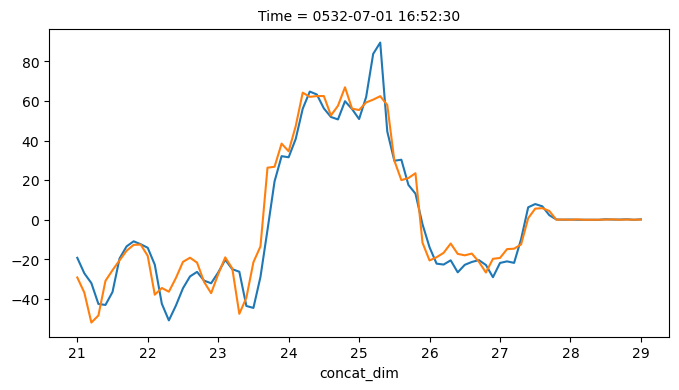

In [59]:
# Plot water mass transformation # March of year 531-533
fig = plt.figure (figsize= [8,4])
wmt_annual501to3_v2_1['totalTrans'].plot()
wmt_annual531to3_v2_1['totalTrans'].plot()

In [5]:
wmt.keys()

dict_keys(['heatTrans', 'saltTrans', 'totalTrans'])

In [38]:
np.shape(wmt_march501to3['totalTrans'])

(81,)

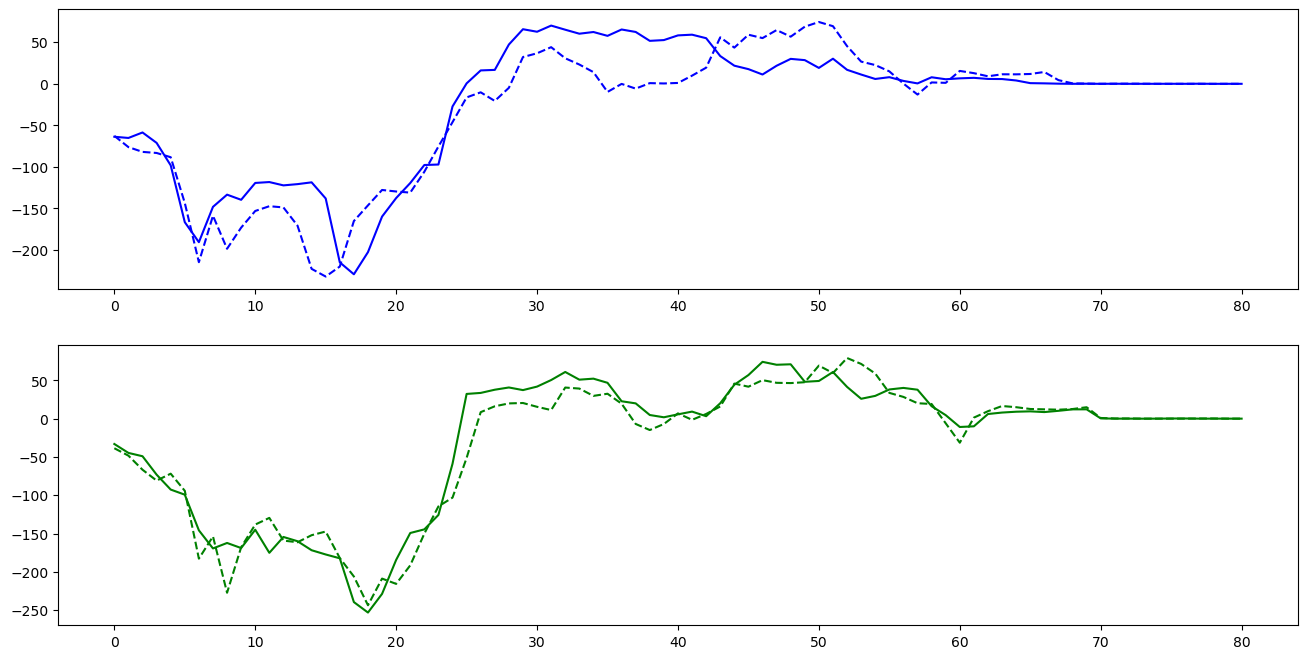

In [32]:
fig, ax = plt.subplots(2, 1, figsize = [16, 8])
ax[0].plot(wmt_march501to3['totalTrans'][:], 'b--')
ax[0].plot(wmt_march531to3['totalTrans'][:], 'b-')
ax[1].plot(wmt_march501to3_v2_1['totalTrans'], 'g--')
ax[1].plot(wmt_march531to3_v2_1['totalTrans'], 'g-')

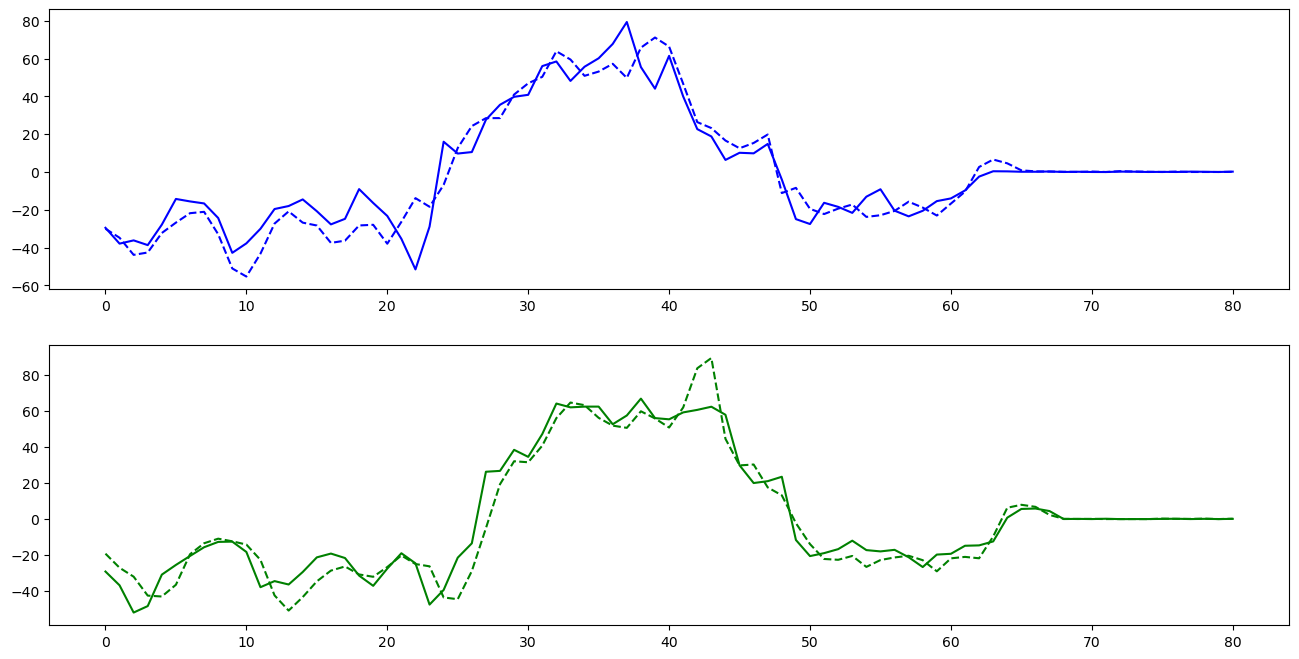

In [58]:
fig, ax = plt.subplots(2, 1, figsize = [16, 8])
ax[0].plot(wmt_annual501to3['totalTrans'][:], 'b--')
ax[0].plot(wmt_annual531to3['totalTrans'][:], 'b-')
ax[1].plot(wmt_annual501to3_v2_1['totalTrans'], 'g--')
ax[1].plot(wmt_annual531to3_v2_1['totalTrans'], 'g-')